In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os
from colossus.cosmology import cosmology
import astropy.units as u
import coop_post_processing as cpp
import matplotlib as mpl
# set fontsize for plots
font = {'family' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)

In [6]:
fix_density = True
constant_comoving = True
# set standard cosmology (Planck 18)
P18 = cosmology.setCosmology('planck18-only') # consistent with the Peak Patch setup
P18_omegam = P18.Om0
P18_omegab = P18.Ob0
P18_h = P18.h
# set values of Omega_M
testmode = False
omegam_varied = np.linspace(P18_omegam-0.1,P18_omegam+0.1,5)
if fix_density:
    addon = '_fix_physdens'
    omh2 = P18_omegam*P18_h**2
    print("Planck18 Omega h^2: ", omh2)
    h_varied = np.sqrt(omh2/omegam_varied)
    H0_varied = 100*h_varied
    omegab_varied = omegam_varied*P18_omegab/P18_omegam # fix the baryon fraction

else:
    addon = ''
    H0_varied = np.full(len(omegam_varied), 100*P18.h)
    omegab_varied = np.full(len(omegam_varied), P18_omegab) # fix the baryon fraction
    
if constant_comoving:
    addon += '_const_comov'


Planck18 Omega h^2:  0.143063263488


OM32_fix_physdens_const_comov_ndmap_100_1e+13_1e+17_z_0pt470_0pt529_smth_20Mpc_35a_gaussian.fits


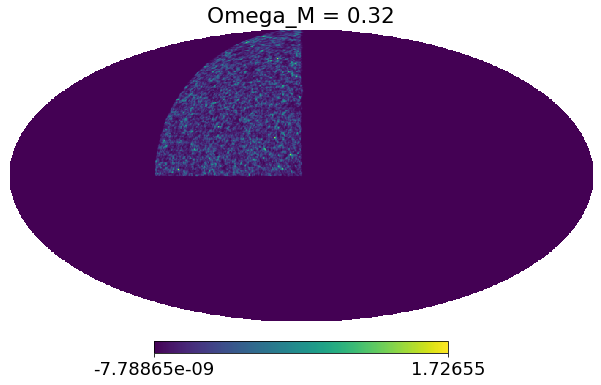

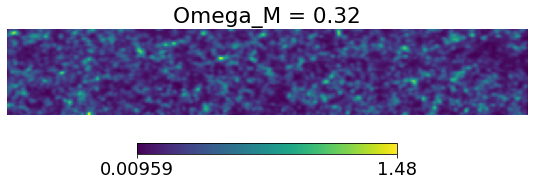

<Figure size 432x288 with 0 Axes>

In [7]:
# check one of the websky maps
# eighth of sky
lonra_plot = [0,90]
latra_plot = [25,40]

for file in os.listdir("/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/"):
    if "35a" in file and "ndmap" in file and "gaussian" in file and addon in file:
        ws = hp.read_map("/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/"+file)
        print(file)
        hp.mollview(ws, title="Omega_M = 0.{:s}".format(file[2:4]))
        hp.cartview(ws,lonra=lonra_plot,latra=latra_plot)
        plt.title("Omega_M = 0.{:s}".format(file[2:4]))
        plt.show()
        plt.clf()



Make a plot for the paper with fiducial cosmology in map, contours for higher

In [8]:
OM22_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[0], H0=H0_varied[0], Ob0=omegab_varied[0])
OM27_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[1], H0=H0_varied[1], Ob0=omegab_varied[1])
OM32_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[2], H0=H0_varied[2], Ob0=omegab_varied[2])
OM37_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[3], H0=H0_varied[3], Ob0=omegab_varied[3])
OM42_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[4], H0=H0_varied[4], Ob0=omegab_varied[4])
OM22_cosmo = OM22_cosmo.toAstropy()
OM27_cosmo = OM27_cosmo.toAstropy()
OM32_cosmo = OM32_cosmo.toAstropy()
OM37_cosmo = OM37_cosmo.toAstropy()
OM42_cosmo = OM42_cosmo.toAstropy()
cosmos = [OM22_cosmo, OM27_cosmo, OM32_cosmo, OM37_cosmo, OM42_cosmo]

### Find lookback time and comoving distance to z=0.5 in this cosmology

In [9]:
for cosmo in cosmos:
    print(cosmo.lookback_time(0.5))
    print(cosmo.age(0.5))
    print(cosmo.comoving_distance(z=0.5))
    

4.4541226560493445 Gyr
8.199111713708477 Gyr
1672.4040907057886 Mpc
4.859910530909438 Gyr
8.416524305207478 Gyr
1822.4286191073802 Mpc
5.212322825620947 Gyr
8.582851300799266 Gyr
1952.2495129655158 Mpc
5.523966699026613 Gyr
8.714710503072896 Gyr
2066.66766587557 Mpc
5.803304652929039 Gyr
8.822071833033135 Gyr
2168.9044793602557 Mpc


In [53]:
smth_size = '10Mpc'
angular_size = 14.68*u.deg
mid = 20*u.deg
L_OM32 = OM32_cosmo.kpc_comoving_per_arcmin(0.5).to(u.Mpc/u.deg)*angular_size
L = round(L_OM32.value)*u.Mpc
if constant_comoving:
    # get all the images in a constant comoving size
    lonra_plot = []
    latra_plot = []
    for cosmo in cosmos:
        comoving_lonra = u.Quantity([-L/2., L/2.])
        comoving_latra = u.Quantity([-L/2., L/2.])
        angular_lonra  = mid+10*u.deg+(comoving_lonra*cosmo.arcsec_per_kpc_comoving(0.5)).to(u.deg)
        angular_latra  = mid+(comoving_latra*cosmo.arcsec_per_kpc_comoving(0.5)).to(u.deg)
        lonra_plot.append(angular_lonra.value)
        latra_plot.append(angular_latra.value)
else:
    lonra_plot = np.stack([mid.value+10-angular_size.value/2,mid.value+10+angular_size.value/2] for i in range(len(cosmos)))
    latra_plot = np.stack([mid.value-angular_size.value/2,mid.value+angular_size.value/2] for i in range(len(cosmos)))

if fix_density:
    avoid = 'avoid'
else:
    avoid = 'fix'
for file in os.listdir("/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/"):
    if smth_size in file and "OM22" in file and "ndmap" in file and "gaussian" in file and addon in file and avoid not in file:
        map22 = "/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/"+file
        print(map22)
        ws_22 = hp.read_map(map22)
        deg2_per_pix, Mpc2_per_pix = cpp.convert_xperpix_phys_units_hp(nside=hp.get_nside(ws_22), redshift=0.5, cosmology=cosmos[0])
        ws_22_msol_per_sqdeg = ws_22/deg2_per_pix.value
        ws_22_msol_per_sqmpc = ws_22/Mpc2_per_pix.value
        print("OM22 Mpc2/perpix: ", Mpc2_per_pix)
        print("OM22 deg2/perpix: ", deg2_per_pix)
    if smth_size in file and "OM27" in file and "ndmap" in file and "gaussian" in file and addon in file  and avoid not in file:
        map27 = "/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/"+file
        print(map27)
        ws_27 = hp.read_map(map27)
        deg2_per_pix, Mpc2_per_pix = cpp.convert_xperpix_phys_units_hp(nside=hp.get_nside(ws_27), redshift=0.5, cosmology=cosmos[1])
        ws_27_msol_per_sqdeg = ws_27/deg2_per_pix.value
        ws_27_msol_per_sqmpc = ws_27/Mpc2_per_pix.value
        print("OM27 Mpc2/perpix: ", Mpc2_per_pix)
        print("OM27 deg2/perpix: ", deg2_per_pix)
    if smth_size in file and "OM32" in file and "ndmap" in file and "gaussian" in file and addon in file and avoid not in file:
        map32 = "/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/"+file
        print(map32)
        ws_32 = hp.read_map(map32)
        deg2_per_pix, Mpc2_per_pix = cpp.convert_xperpix_phys_units_hp(nside=hp.get_nside(ws_32), redshift=0.5, cosmology=cosmos[2])
        ws_32_msol_per_sqdeg = ws_32/deg2_per_pix.value
        ws_32_msol_per_sqmpc = ws_32/Mpc2_per_pix.value
        print("OM32 Mpc2/perpix: ", Mpc2_per_pix)
        print("OM32 deg2/perpix: ", deg2_per_pix)
    if smth_size in file and "OM37" in file and "ndmap" in file and "gaussian" in file and addon in file and avoid not in file:
        map37 = "/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/"+file
        print(map37)
        ws_37 = hp.read_map(map37)
        deg2_per_pix, Mpc2_per_pix = cpp.convert_xperpix_phys_units_hp(nside=hp.get_nside(ws_37), redshift=0.5, cosmology=cosmos[3])
        ws_37_msol_per_sqdeg = ws_37/deg2_per_pix.value
        ws_37_msol_per_sqmpc = ws_37/Mpc2_per_pix.value
        print("OM37 Mpc2/perpix: ", Mpc2_per_pix)
        print("OM37 deg2/perpix: ", deg2_per_pix)
    if smth_size in file and "OM42" in file and "ndmap" in file and "gaussian" in file and addon in file and avoid not in file:
        map42 = "/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/"+file
        print(map42)
        ws_42 = hp.read_map(map42)
        deg2_per_pix, Mpc2_per_pix = cpp.convert_xperpix_phys_units_hp(nside=hp.get_nside(ws_42), redshift=0.5, cosmology=cosmos[4])
        ws_42_msol_per_sqdeg = ws_42/deg2_per_pix.value
        ws_42_msol_per_sqmpc = ws_42/Mpc2_per_pix.value
        print("OM42 Mpc2/perpix: ", Mpc2_per_pix)
        print("OM42 deg2/perpix: ", deg2_per_pix)


/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/OM32_fix_physdens_const_comov_ndmap_100_1e+13_1e+17_z_0pt470_0pt529_smth_10Mpc_17a_gaussian.fits
OM32 Mpc2/perpix:  0.2378917430041088 Mpc2
OM32 deg2/perpix:  0.00020490567510038252 deg2
/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/OM42_fix_physdens_const_comov_ndmap_100_1e+13_1e+17_z_0pt472_0pt527_smth_10Mpc_15a_gaussian.fits
OM42 Mpc2/perpix:  0.2936226631697704 Mpc2
OM42 deg2/perpix:  0.00020490567510038252 deg2
/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/OM37_fix_physdens_const_comov_ndmap_100_1e+13_1e+17_z_0pt471_0pt528_smth_10Mpc_16a_gaussian.fits
OM37 Mpc2/perpix:  0.2665937794111687 Mpc2
OM37 deg2/perpix:  0.00020490567510038252 deg2
/mnt/raid-cita/mlokken/pkpatch/number_density_maps/alt_cosmo/OM27_fix_physdens_const_comov_ndmap_100_1e+13_1e+17_z_0pt468_0pt531_smth_10Mpc_18a_gaussian.fits
OM27 Mpc2/perpix:  0.20730499942595706 Mpc2
OM27 deg2/perpix:  0.00020490567510038252 deg2
/mnt/ra

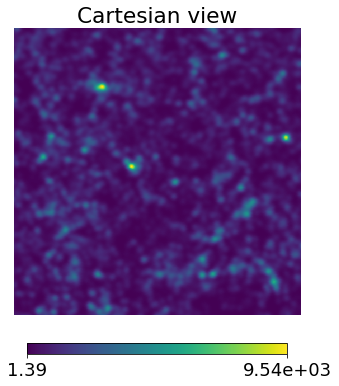

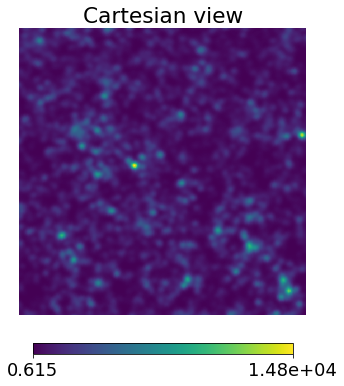

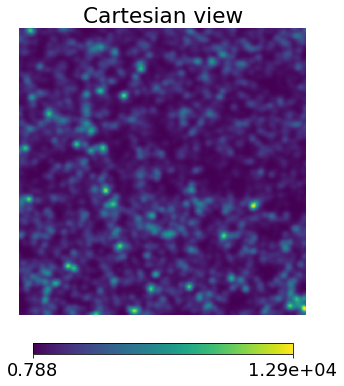

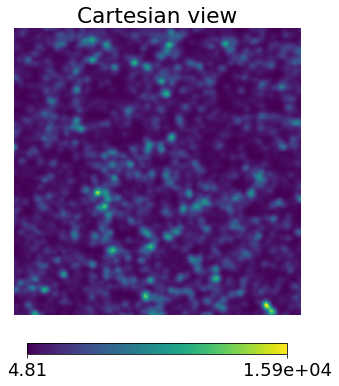

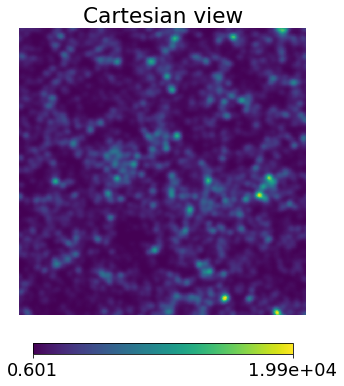

In [54]:
img_22_msolperdeg2 = hp.cartview(ws_22_msol_per_sqdeg,lonra=lonra_plot[0],latra=latra_plot[0], return_projected_map=True)
img_27_msolperdeg2 = hp.cartview(ws_27_msol_per_sqdeg,lonra=lonra_plot[1],latra=latra_plot[1], return_projected_map=True)
img_32_msolperdeg2 = hp.cartview(ws_32_msol_per_sqdeg,lonra=lonra_plot[2],latra=latra_plot[2], return_projected_map=True)
img_37_msolperdeg2 = hp.cartview(ws_37_msol_per_sqdeg,lonra=lonra_plot[3],latra=latra_plot[3], return_projected_map=True)
img_42_msolperdeg2 = hp.cartview(ws_42_msol_per_sqdeg,lonra=lonra_plot[4],latra=latra_plot[4], return_projected_map=True)
imgs_persqdeg = [img_22_msolperdeg2, img_27_msolperdeg2, img_32_msolperdeg2, img_37_msolperdeg2, img_42_msolperdeg2]

1.2847324062893426 arcmin
160.0
1.1789716805440429 arcmin
159.99999999999997
1.1005722974809828 arcmin
160.0
1.0396406578656707 arcmin
159.99999999999997
0.990634558684825 arcmin
160.00000000000003


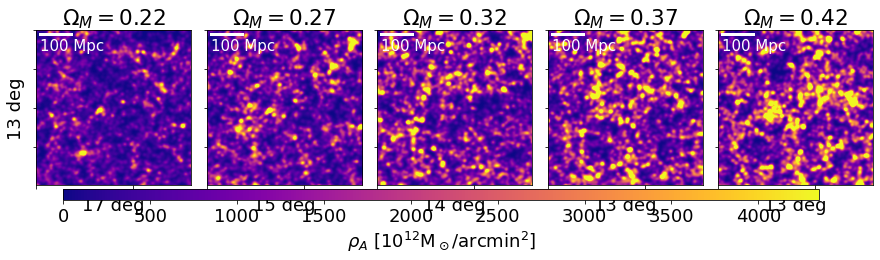

In [55]:
# plot the maps in Msol/deg2
cmap = 'plasma'

if not constant_comoving:
    length = (lonra_plot[1]-lonra_plot[0])*u.deg
    height = (latra_plot[1]-latra_plot[0])*u.deg
    arcmin_per_pix = length.to(u.arcmin)/img_32_msolperdeg2.shape[1]
    len_in_arcmin  = arcmin_per_pix*img_32_msolperdeg2.shape[1]
    ht_in_arcmin   = arcmin_per_pix*img_32_msolperdeg2.shape[0]

fig, ax = plt.subplots(1,5,figsize=[15,3])
vmin = 0
vmax = 4350
imgs = [img_22_msolperdeg2, img_27_msolperdeg2, img_32_msolperdeg2, img_37_msolperdeg2, img_42_msolperdeg2]


for i in range(5):
    # get the scale in Mpc for each cosmo
    length = (lonra_plot[i][1]-lonra_plot[i][0])*u.deg
    height = (latra_plot[i][1]-latra_plot[i][0])*u.deg
    arcmin_per_pix = length.to(u.arcmin)/imgs[i].shape[1]
    len_in_arcmin  = arcmin_per_pix*imgs_persqdeg[i].shape[1]
    ht_in_arcmin   = arcmin_per_pix*imgs_persqdeg[i].shape[0]
    mpc_per_arcmin = cosmos[i].kpc_comoving_per_arcmin(0.5).to(u.Mpc/u.arcmin)
    mpc_per_pix = arcmin_per_pix*mpc_per_arcmin    
    print(arcmin_per_pix)
    scale_in_mpc = 100 * u.Mpc
    scale_in_pix = scale_in_mpc / mpc_per_pix
    print(scale_in_pix)
    implot = ax[i].imshow(imgs[i], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].plot([20,scale_in_pix+20],[20,20], color='white', linewidth=3)
    ax[i].text(20, 100, "100 Mpc", color='white', fontsize=15)
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].set_xlabel("{:s} deg".format(str(int(len_in_arcmin.value/60))))
    ax[i].set_title(r"$\Omega_M = {:0.2f}$".format(cosmos[i].Om0))
ax[0].set_ylabel("{:s} deg".format(str(int(ht_in_arcmin.value/60))))

# add a new axis below for a horizontal colorbar
fig.subplots_adjust(bottom=0.15)
plt.subplots_adjust(wspace=0.1, hspace=0.17)
ax_cbar = fig.add_axes([0.15, 0.09, 0.7, 0.05])
cbar = fig.colorbar(implot, cax=ax_cbar, orientation='horizontal', label=r'$\rho_{A}$ [$10^{12}\rm{M_\odot}/\rm{arcmin}^2]$')




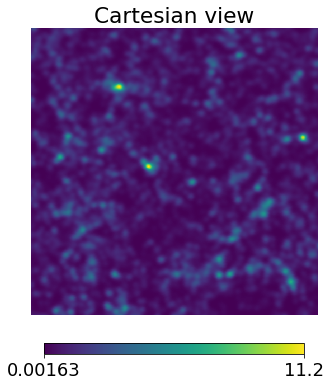

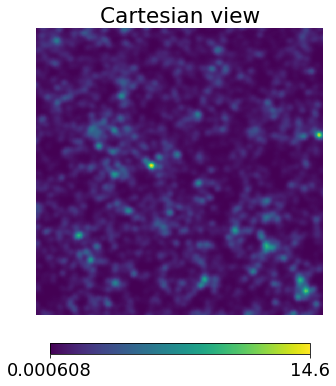

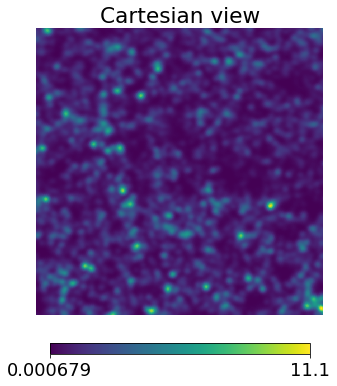

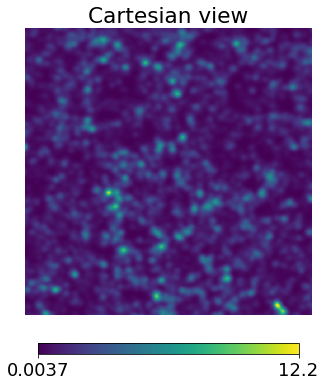

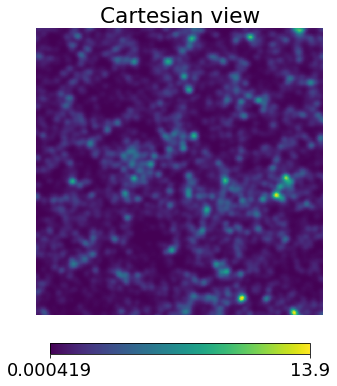

In [56]:
img_22_msolpermpc2 = hp.cartview(ws_22_msol_per_sqmpc,lonra=lonra_plot[0],latra=latra_plot[0], return_projected_map=True)
img_27_msolpermpc2 = hp.cartview(ws_27_msol_per_sqmpc,lonra=lonra_plot[1],latra=latra_plot[1], return_projected_map=True)
img_32_msolpermpc2 = hp.cartview(ws_32_msol_per_sqmpc,lonra=lonra_plot[2],latra=latra_plot[2], return_projected_map=True)
img_37_msolpermpc2 = hp.cartview(ws_37_msol_per_sqmpc,lonra=lonra_plot[3],latra=latra_plot[3], return_projected_map=True)
img_42_msolpermpc2 = hp.cartview(ws_42_msol_per_sqmpc,lonra=lonra_plot[4],latra=latra_plot[4], return_projected_map=True)
imgs_persqmpc = [img_22_msolpermpc2, img_27_msolpermpc2, img_32_msolpermpc2, img_37_msolpermpc2, img_42_msolpermpc2]

0.625 Mpc
0.6250000000000001 Mpc
0.625 Mpc
0.6250000000000001 Mpc
0.6249999999999999 Mpc
altcosmo_ndmaps_20Mpc__fix_physdens_const_comov.png


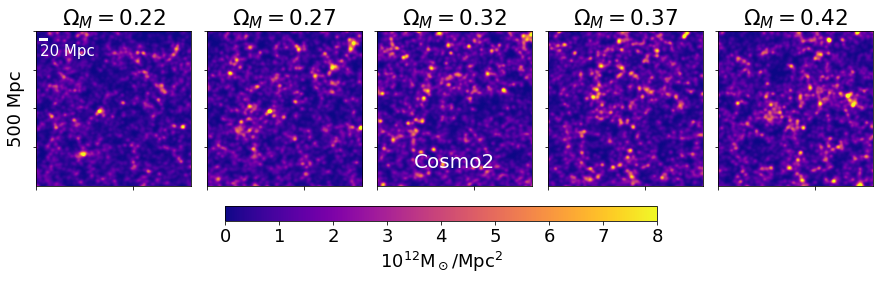

In [57]:

fig, ax = plt.subplots(1,5,figsize=[15,4])

vmin = 0
vmax = 8

for i in range(5):
    # get the scale in Mpc for each cosmo
    length = (lonra_plot[i][1]-lonra_plot[i][0])*u.deg
    height = (latra_plot[i][1]-latra_plot[i][0])*u.deg
    arcmin_per_pix = length.to(u.arcmin)/imgs_persqmpc[i].shape[1]
    mpc_per_arcmin = cosmos[i].kpc_comoving_per_arcmin(0.5).to(u.Mpc/u.arcmin)
    mpc_per_pix = arcmin_per_pix*mpc_per_arcmin
    print(mpc_per_pix)
    scale_in_mpc = 20*u.Mpc
    scale_in_pix = scale_in_mpc / mpc_per_pix
    implot = ax[i].imshow(imgs_persqmpc[i], vmin=vmin, vmax=vmax, cmap=cmap)
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    # ax[i].set_xlabel("{:s} deg".format(str(int(len_in_arcmin.value/60))))
    ax[i].set_title(r"$\Omega_M = {:0.2f}$".format(cosmos[i].Om0))
ax[0].set_ylabel("{:d} Mpc".format(int(L.value)))
ax[0].plot([20,scale_in_pix+20],[40,40], color='white', linewidth=3)
ax[0].text(20, 130, "20 Mpc", color='white', fontsize=15)
# add text in whitespace describing the set of cosmological variations
if fix_density:
    cosmo_label = 'Cosmo2'
    text1 = r"Cosmo2: $\Omega_M h^2$ fixed,"
    text2 = r"$H_0$ varied"
else:
    cosmo_label= 'Cosmo1'
    text1 = r"Cosmo1: $\Omega_M h^2$ varied,"
    text2 = r"$H_0$ fixed"
plt.text(0.5, 0.15, cosmo_label, horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=20, color = 'white')

# add a new axis below for a horizontal colorbar
fig.subplots_adjust(bottom=0.1)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax_cbar = fig.add_axes([0.3, 0.1, 0.4, 0.05])
cbar = fig.colorbar(implot, cax=ax_cbar, orientation='horizontal', label=r'$10^{12}\rm{M_\odot}/\rm{Mpc}^2$')
print("altcosmo_ndmaps_20Mpc_{:s}.png".format(addon))
plt.savefig("../../plots/paper2/altcosmo_ndmaps_{:s}_{:s}.pdf".format(smth_size, addon), dpi=300, bbox_inches="tight")


In [59]:
for cosmo in cosmos:
    # get the comoving scale corresponding ot 35 arcmin
    print(cosmo.kpc_comoving_per_arcmin(0.5).to(u.Mpc/u.arcmin)*35*u.arcmin)
    

17.026892053872107 Mpc
18.554304875165165 Mpc
19.876022729327318 Mpc
21.04092393318694 Mpc
22.081805856885747 Mpc
